In [1]:
from preproces_books import preprocess_books
#preprocess_books()

In [2]:
import pickle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt

In [3]:
with open('../data/usuaris.pkl', 'rb') as file:
    usuaris = pickle.load(file)
llibres = pd.read_pickle('../data/books_clean.pkl')

In [4]:
# Dimensiones de los vectores de usuario y libro
dim_usuari = usuaris[0].vector.shape[0]
dim_llibre = len(llibres["vector"].iloc[0])

# Entradas
entrada_usuari = Input(shape=(dim_usuari,), name='entrada_usuari')
entrada_llibre = Input(shape=(dim_llibre,), name='entrada_llibre')

# Procesamiento de las entradas
proc_usuari = Dense(64, activation='relu')(entrada_usuari)
proc_llibre = Dense(64, activation='relu')(entrada_llibre)

# Combinación de características
combinacio = Concatenate()([proc_usuari, proc_llibre])

# Capas ocultas
oculta1 = Dense(256, activation='relu')(combinacio)
oculta2 = Dense(128, activation='relu')(oculta1)
oculta3 = Dense(64, activation='relu')(oculta2)

# Capa de salida
sortida = Dense(1, activation='linear')(oculta3)

# Creación del modelo
model = Model(inputs=[entrada_usuari, entrada_llibre], outputs=sortida)

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 entrada_usuari (InputLayer  [(None, 53)]                 0         []                            
 )                                                                                                
                                                                                                  
 entrada_llibre (InputLayer  [(None, 53)]                 0         []                            
 )                                                                                                
                                                                                                  
 dense (Dense)               (None, 64)                   3456      ['entrada_usuari[0][0]']      
                                                                                              

In [5]:
def vector_llibre(id_llibre):
    return llibres[llibres["isbn13"] == id_llibre]["vector"].iloc[0]

In [6]:
# Inicializa listas vacías para almacenar los datos
vectores_usuarios = []
vectores_libros = []
puntuaciones = []

for user in usuaris:
    # Obtiene el vector del usuario
    vector_usuario = user.vector

    # Para cada libro leído y su puntuación
    for isbn, val in zip(user.llibres_usuari, user.val_llibres):
        # Obtiene el vector del libro (modifica esto según tu implementación)
        vector_libro = vector_llibre(isbn)

        # Añade los datos al conjunto de datos
        vectores_usuarios.append(vector_usuario)
        vectores_libros.append(vector_libro)
        puntuaciones.append(val)

    # Repite para los libros recomendados
    for isbn, punt in zip(user.llibres_recomanats, user.puntuacio_llibres):
        # Obtiene el vector del libro (modifica esto según tu implementación)
        vector_libro = vector_llibre(isbn)

        # Añade los datos al conjunto de datos
        vectores_usuarios.append(vector_usuario)
        vectores_libros.append(vector_libro)
        puntuaciones.append(punt)

# Convertir las listas en arrays de NumPy para su uso con TensorFlow/Keras
import numpy as np

vectores_usuarios_np = np.array(vectores_usuarios)
vectores_libros_np = np.array(vectores_libros)
puntuaciones_np = np.array(puntuaciones)

In [7]:
print(vectores_usuarios_np.shape)
print(vectores_libros_np.shape)
print(puntuaciones_np.shape)

(800, 53)
(800, 53)
(800,)


In [8]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    np.hstack((vectores_usuarios_np, vectores_libros_np)),  # Concatenar vectores de usuario y libro
    puntuaciones_np, 
    test_size=0.2, 
    random_state=42
)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(640, 106)
(160, 106)
(640,)
(160,)


In [10]:
# Entrenamiento del modelo
historial = model.fit(
    [X_train[:, :53], X_train[:, 53:]],  # Separar los vectores de usuario y libro
    y_train, 
    epochs=10,
    batch_size=8,
    validation_split=0.2
)

Epoch 1/10
64/64 [==============================] - 0s 3ms/step - loss: 3.6318 - val_loss: 3.0861
Epoch 2/10
64/64 [==============================] - 0s 1ms/step - loss: 2.8010 - val_loss: 3.0471
Epoch 3/10
64/64 [==============================] - 0s 1ms/step - loss: 2.5701 - val_loss: 3.2563
Epoch 4/10
64/64 [==============================] - 0s 1ms/step - loss: 2.3452 - val_loss: 3.5061
Epoch 5/10
64/64 [==============================] - 0s 1ms/step - loss: 1.9935 - val_loss: 3.8761
Epoch 6/10
64/64 [==============================] - 0s 2ms/step - loss: 1.5498 - val_loss: 3.9658
Epoch 7/10
64/64 [==============================] - 0s 1ms/step - loss: 1.0583 - val_loss: 4.0754
Epoch 8/10
64/64 [==============================] - 0s 1ms/step - loss: 0.6448 - val_loss: 4.6314
Epoch 9/10
64/64 [==============================] - 0s 1ms/step - loss: 0.4601 - val_loss: 4.3855
Epoch 10/10
64/64 [==============================] - 0s 1ms/step - loss: 0.2991 - val_loss: 4.3736


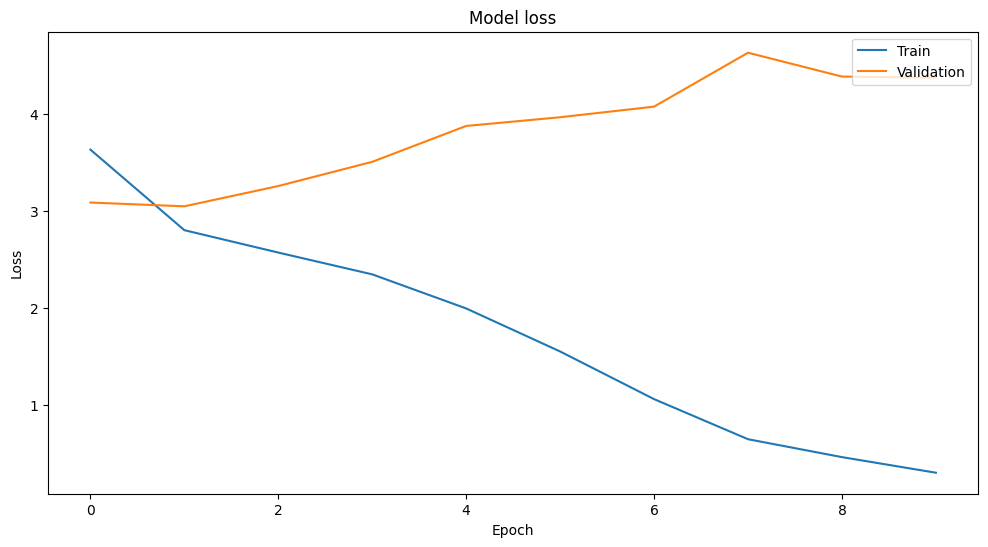

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [12]:
# Evaluación del modelo con el conjunto de prueba
evaluacion = model.evaluate(
    [X_test[:, :53], X_test[:, 53:]], 
    y_test
)

print(f'Pérdida en el conjunto de prueba: {evaluacion}')

5/5 [==============================] - 0s 1ms/step - loss: 4.6497
Pérdida en el conjunto de prueba: 4.649716377258301


In [13]:
# Realizar predicciones en el conjunto de prueba
predicciones = model.predict([X_test[:, :53], X_test[:, 53:]])

# Print predictions and actual values
print('Predicciones: ', np.round(predicciones.flatten()[:10],0))
print('Valores reales: ', y_test[:10])

# Definir un umbral de aceptación
umbral = 0.5

# Calcular el número de predicciones "correctas"
predicciones_correctas = np.abs(predicciones.flatten() - y_test) <= umbral

# Calcular la precisión
precision = np.mean(predicciones_correctas)
print(f'Precisión aproximada: {precision * 100:.2f}%')

5/5 [==============================] - 0s 1ms/step
Predicciones:  [4. 2. 4. 2. 3. 2. 1. 2. 3. 2.]
Valores reales:  [4 1 2 3 4 2 5 0 3 5]
Precisión aproximada: 24.38%


In [14]:
# Guardar el modelo completo
model.save('prediccio_puntuacio.keras')